# Test Finite Differences Poisson

In [1]:
%matplotlib inline
import numpy as np
from scipy import linalg
from scipy import sparse
from scipy.sparse import linalg as la
import matplotlib.pyplot as plt

# Normal Finite Differences kernel on a 2D grid...

1. 

In [2]:
Nx = 201
Ny = 201
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)
dX = np.diff(X, axis=1) # Columns
dY = np.diff(Y, axis=0) # Rows
hx = dX.mean()
hy = dY.mean()

In [3]:
X.ravel() # Fast changing index...


array([0.   , 0.005, 0.01 , ..., 0.99 , 0.995, 1.   ])

In [4]:
hy

0.005000000000000001

In [5]:
dY

array([[0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005],
       [0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005],
       [0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005],
       ...,
       [0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005],
       [0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005],
       [0.005, 0.005, 0.005, ..., 0.005, 0.005, 0.005]])

In [6]:
Phi_exact = X**3 + 2 * Y**3
source = -6 * X + -12 * Y
f0 = source.ravel()

In [276]:
def boundary(Nx, Ny):
    bc = np.zeros(Nx*Ny,dtype=bool)
    for i in range(Ny):
        for j in range(Nx):
            if i == 0 or j == 0 or i == (Ny-1) or j == (Nx-1):
                ind = i * Nx + j # This point
                bc[ind] = True
    return bc

def boundary_radial(Nx, Ny):
    bc = np.zeros(Nx*Ny,dtype=bool)
    for i in range(Ny):
        for j in range(Nx):
            if i == 0 or i == (Ny-1) or j == (Nx-1):
                ind = i * Nx + j # This point
                bc[ind] = True
    return bc

In [10]:
def poisson_equally_spaced(Nx, Ny, hx, hy):
    A = sparse.lil_matrix((Nx*Ny, Nx*Ny))
    for i in range(Ny):
        for j in range(Nx):
            ind = i * Nx + j # This point
            ixp = ind + 1    # +x 
            ixn = ind - 1    # -x
            iyp = (i+1)*Nx + j  # +y
            iyn = (i-1)*Nx + j  # -y

            A[ind, ind] = 2 / hx**2 + 2 / hy**2
            if j < (Nx - 1):
                A[ind, ixp] = -1 / hx**2
            if j > 0:
                A[ind, ixn] = -1 / hx**2

            if i > 0:
                A[ind, iyn] = -1 / hy**2
            if i < (Ny-1):
                A[ind, iyp] = -1 / hy**2
    
    return sparse.csr_matrix(A) # Convert to better format for usage
        

In [527]:
def poisson_variable_spacing(x, y):
    Nx = len(x)
    Ny = len(y)
    hx = np.diff(x)
    hy = np.diff(y)
    A = sparse.lil_matrix((Nx*Ny, Nx*Ny))
    for i in range(Ny):
        for j in range(Nx):
            ind = i * Nx + j # This point
            ixp = ind + 1    # +x 
            ixn = ind - 1    # -x
            iyp = (i+1)*Nx + j  # +y
            iyn = (i-1)*Nx + j  # -y
            
            
            Dx_plus = hx[j] if j < (Nx-1) else 0.0
            Dx_minus = hx[j-1] if j > 0 else 0.0
            Dy_plus = hy[i] if i < (Ny-1) else 0.0
            Dy_minus = hy[i-1] if i > 0 else 0.0
            
            prefactor_x = 4/((Dx_plus+Dx_minus)*(Dx_plus**2 + Dx_minus**2))
            
            prefactor_y = 4/((Dy_plus+Dy_minus)*(Dy_plus**2 + Dy_minus**2))

            
            A[ind, ind] = (Dx_plus+Dx_minus) * prefactor_x + (Dy_plus+Dy_minus) * prefactor_y
            if j < (Nx - 1):
                A[ind, ixp] = -1 * Dx_minus * prefactor_x
            if j > 0:
                A[ind, ixn] = -1 * Dx_plus * prefactor_x

            if i > 0:
                A[ind, iyn] = -1 * Dy_plus * prefactor_y
            if i < (Ny-1):
                A[ind, iyp] = -1 * Dy_minus * prefactor_y
    
    return sparse.csr_matrix(A) # Convert to better format for usage


def poisson_variable_spacing_radial(x, y):
    Nx = len(x)
    Ny = len(y)
    hx = np.diff(x)
    hy = np.diff(y)
    A = sparse.lil_matrix((Nx*Ny, Nx*Ny))
    for i in range(Ny):
        for j in range(Nx): # Radial
            ind = i * Nx + j # This point
            ixp = ind + 1    # +x 
            ixn = ind - 1    # -x
            iyp = (i+1)*Nx + j  # +y
            iyn = (i-1)*Nx + j  # -y
            
            
            Dx_plus = hx[j] if j < (Nx-1) else 0.0
            Dx_minus = hx[j-1] if j > 0 else hx[j]
            x0 = x[j]
            Dy_plus = hy[i] if i < (Ny-1) else 0.0
            Dy_minus = hy[i-1] if i > 0 else 0.0
            
            prefactor_x = 4/((Dx_plus+Dx_minus)*(Dx_plus**2 + Dx_minus**2))
            
            prefactor_y = 4/((Dy_plus+Dy_minus)*(Dy_plus**2 + Dy_minus**2))

            
            A[ind, ind] = (Dx_plus+Dx_minus) * prefactor_x + (Dy_plus+Dy_minus) * prefactor_y
            if j == 0:
                A[ind, ixp] = -2 * Dx_minus * prefactor_x # That's it, no radial derivative here...
            elif j < (Nx - 1):
                A[ind, ixp] = -1 * Dx_minus * prefactor_x + -1 / (x0 * (Dx_plus+Dx_minus))
            
                
            
            if j > 0:
                A[ind, ixn] = -1 * Dx_plus * prefactor_x + 1 / (x0 * (Dx_plus+Dx_minus))
            
            if j == (Nx - 1):
                A[ind, ind] += -1 / (x0 * (Dx_plus+Dx_minus)) # 1st order difference uses the grid point here...

            if i > 0:
                A[ind, iyn] = -1 * Dy_plus * prefactor_y
            if i < (Ny-1):
                A[ind, iyp] = -1 * Dy_minus * prefactor_y
    
    return sparse.csr_matrix(A) # Convert to better format for usage


def grid_area(r, z):
    # Area of each grid element is 2 * np.pi * 
    dr2 = np.diff(r**2)
    return 2 * np.pi *  np.diff(z).reshape((-1, 1)) @ dr2.reshape((1, -1))

In [490]:
A = poisson_equally_spaced(Nx, Ny, hx, hy)
bc = boundary(Nx, Ny)

In [491]:
bc.reshape((Ny, Nx))

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       ...,
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False, False,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [412]:
u = np.zeros(Nx*Ny)
u[bc] = Phi_exact.ravel()[bc]

In [413]:
u.reshape((Ny, Nx))

array([[1.90519501e-03, 1.31509372e-02, 4.09719333e-02, ...,
        1.21201918e+01, 1.22955469e+01, 1.24641166e+01],
       [2.97929661e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.24651907e+01],
       [5.77083608e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.24679823e+01],
       ...,
       [5.65709473e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.81193062e+01],
       [5.79318402e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.82553955e+01],
       [5.92830690e+00, 5.93955265e+00, 5.96737364e+00, ...,
        1.80465935e+01, 1.82219486e+01, 1.83905183e+01]])

In [414]:
f = f0 - A @ u
A_cut = A[~bc].T[~bc].T # 
f_cut = f[~bc]

ValueError: operands could not be broadcast together with shapes (391251,) (3111,) 

In [415]:
u_cut = la.spsolve(A_cut, f_cut)
u[~bc] = u_cut

ValueError: NumPy boolean array indexing assignment cannot assign 385430 input values to the 2891 output values where the mask is true

In [ ]:
%time la.spsolve(A_cut, f_cut)

In [ ]:
u.reshape((Ny, Nx))

In [ ]:
Phi_exact

In [ ]:
abs(u.reshape((Ny, Nx)) - Phi_exact).mean()

# 

- For a 101x101 matrix, it takes 1.0 s system time (6.73 s wall time)
- Using sparse matrices, it takes 79 ms wall time (
- Using a 201x201 matrix, it takes only 379 ms wall time (just over 4x the time...)

# Variable grid test

In [ ]:
ddx = list(reversed([0.0105 * 1.05**i for i in range(51)]))
x = np.cumsum(ddx)
ddy = list(reversed([0.011 * 1.023**i for i in range(61)]))
ddy
y = np.cumsum(ddy)

In [ ]:
y

In [ ]:

Nx, Ny = len(x), len(y)

In [ ]:
X, Y = np.meshgrid(x, y)
dX = np.diff(X, axis=1) # Columns
dY = np.diff(Y, axis=0) # Rows
hx = dX.mean()
hy = dY.mean()
Phi_exact = X**3 + 2 * Y**3
Ex_exact = 3*(x[1:]*0.5+x[:-1]*0.5)**2
source = -6 * X + -12 * Y
f0 = source.ravel()

In [ ]:
A = poisson_variable_spacing(x, y)
bc = boundary(len(x), len(y))

In [ ]:
u = np.zeros(Nx*Ny)
u[bc] = Phi_exact.ravel()[bc]

In [ ]:
# Add some functions to do this...
f = f0 - A @ u
A_cut = A[~bc].T[~bc].T # 
f_cut = f[~bc]

In [ ]:
u_cut = la.spsolve(A_cut, f_cut)
u[~bc] = u_cut

In [ ]:
abs(u.reshape((Ny, Nx)) - Phi_exact).mean()

# Seems to be a working variable grid solver!

(Note: Only works for constant $\varepsilon_r = 1$...)

In [ ]:
A[0:6, 0:6].toarray()

In [ ]:
f_cut[:32]

In [537]:
def E_field(u, r, z):
    """Works for r, z (cylindrical coordinates), or x, y (Cartesian coordinates)."""
    Ny = len(z)
    Nx = len(r)
    Ey1 = np.diff(u.reshape((Ny, Nx)), axis=0) / np.diff(z).reshape((-1, 1))
    Ex1 = np.diff(u.reshape((Ny, Nx)), axis=1) / np.diff(r).reshape((1, -1))
    Ex = 0.5 * (Ex1[:-1, :] + Ex1[1:, :])
    Ey = 0.5 * (Ey1[:, :-1] + Ey1[:, 1:])
    return Ex + 1j*Ey

In [ ]:
Ey1 = np.diff(u.reshape((Ny, Nx)), axis=0) / np.diff(y).reshape((-1, 1))
Ex1 = np.diff(u.reshape((Ny, Nx)), axis=1) / np.diff(x).reshape((1, -1))

In [ ]:
Ex = 0.5 * (Ex1[:-1, :] + Ex1[1:, :])
Ey = 0.5 * (Ey1[:, :-1] + Ey1[:, 1:])
E = Ex + 1j*Ey

In [ ]:
V = u.reshape((Ny, Nx))
V_midpt = (V[:-1, :-1] + V[1:, :-1] + V[1:, 1:] + V[:-1, 1:])*0.25

In [ ]:
abs(E)**2

In [ ]:
dV = np.diff(y).reshape((-1, 1)) @ np.diff(x).reshape((1, -1))

In [ ]:
dV.shape

In [ ]:
abs(Ex_exact - Ex).mean()

In [ ]:
(abs(Ex_exact - Ex)/Ex).mean() * 100.0

In [ ]:
np.sum(abs(E)**2 * dV)

In [ ]:
def E_stored_exact(x, y):
    xi = x[0]
    xf = x[-1]
    yi = y[0]
    yf = y[-1]
    return 9/5 * ((xf**5 - xi**5) * (yf - yi) + 4 * (xf - xi) * (yf**5 - yi**5))

In [ ]:
E_stored(x, y)

In [ ]:
1500*1500*8/(1024**2)

# To Do

- Use the r, z grids...
- Need to use the correct volume of each mesh when switching to a radial grid (

- Sphere over a metal plane example

In [606]:
Rtip = 20.0
Zmax = 12
Rmax = 12
d_R = 1
z = np.linspace(-Rtip*d_R, Rtip*Zmax, (Zmax+d_R)*100+1)
r = np.linspace(0, Rmax*Rtip, Rmax*100+1)

In [607]:
R, Z = np.meshgrid(r, z)

In [608]:
import capsol

In [609]:
sphere = capsol.sphere(R, Z, Rtip) # Returns whether a point is on the sphere...

In [610]:
u = np.zeros_like(R)
u[sphere] = 1.0

In [611]:
outer_boundary = boundary_radial(len(r), len(z))

In [612]:
R.ravel()[outer_boundary]

array([0.000e+00, 2.000e-01, 4.000e-01, ..., 2.396e+02, 2.398e+02,
       2.400e+02])

In [613]:
full_boundary = sphere.ravel() + outer_boundary

In [614]:
A = poisson_variable_spacing_radial(r, z)

In [615]:
f0 = np.zeros_like(u.ravel())

In [616]:
f = f0 - A @ u.ravel()

In [617]:
A_cut = A[~full_boundary].T[~full_boundary].T # 
f_cut = f[~full_boundary]

In [618]:
%time u_cut = la.spsolve(A_cut, f_cut)

CPU times: user 10min 42s, sys: 12.2 s, total: 10min 54s
Wall time: 58.5 s


In [619]:
u = u.ravel()
u[~full_boundary] = u_cut

In [620]:
#%time uc_cg = la.cg(A_cut, f_cut)

In [621]:
# abs(uc_cg[0] - u_cut).max()

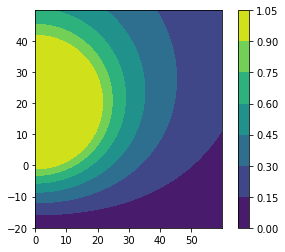

In [622]:
fig, ax = plt.subplots()
s = np.s_[:350, :300]
plt.contourf(R[s], Z[s], u.reshape((len(z), len(r)))[s])
plt.colorbar()
ax.set_aspect('equal')

101

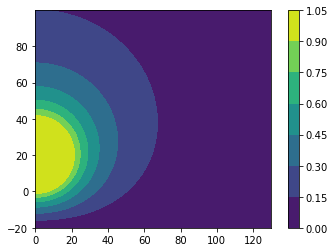

In [623]:
fig, ax = plt.subplots()
s = np.s_[:600, :650]
plt.contourf(R[s], Z[s], u.reshape((len(z), len(r)))[s])
plt.colorbar()
ax.set_aspect('equal')

In [624]:
dV = grid_area(r, z)
E_rz = E_field(u, r, z)
dEng = dV * abs(E_rz)**2
np.sum(dEng)

672.2217718096504

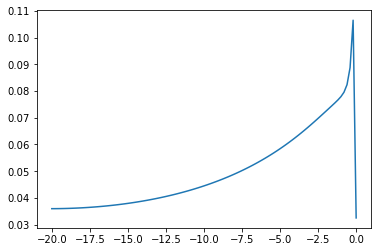

In [635]:
iZmax = np.argmax(z>0)
s_ = np.s_[:iZmax]
plt.plot(z[:iZmax], E_rz[:iZmax, 0].imag)

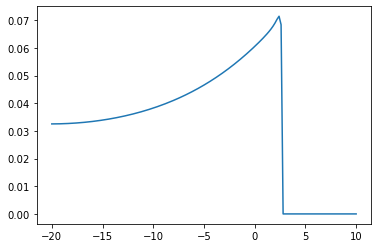

In [637]:
iZmax = np.argmax(z>10)
s_ = np.s_[:iZmax]
plt.plot(z[:iZmax], E_rz[:iZmax, 50].imag)

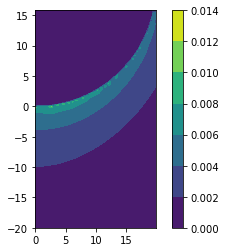

In [625]:
fig, ax = plt.subplots()
s = np.s_[:180, :100]
plt.contourf(R[s], Z[s], (abs(E_rz)**2)[s])
plt.colorbar()
ax.set_aspect('equal')

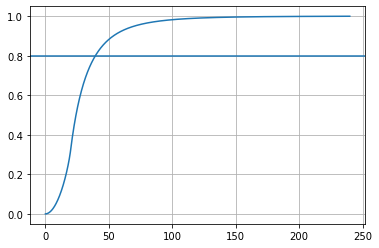

In [626]:
dEng_dr = dEng.sum(axis=0)
plt.plot(r[:-1], np.cumsum(dEng_dr)/sum(dEng_dr))
plt.axhline(0.8)
plt.grid()

In [573]:
len(r)

601

- This looks correct!

In [ ]:
dV = grid_area(r, z)
E_rz = E_field(u, r, z)
dV * abs(E_rz)**2

In [366]:
rr = R[outer_boundary.reshape((len(z), len(r)))]
zz = Z[outer_boundary.reshape((len(z), len(r)))]

In [367]:
sum(zz == -20.0)

601

In [368]:
sum(R[sphere] == 0.0)

101

In [369]:
full_boundary

array([ True,  True,  True, ...,  True,  True,  True])

In [370]:
sphere.ravel()

array([False, False, False, ..., False, False, False])

(-20.0, 50.0)

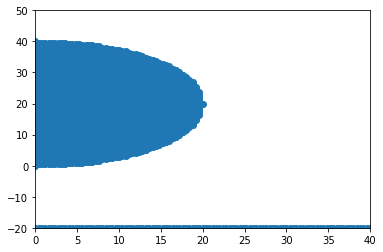

In [371]:
plt.scatter(R.ravel()[full_boundary], Z.ravel()[full_boundary])
plt.xlim(0, 40)
plt.ylim(-20, 50)

# Check using normal solver

In [533]:
Rtip = 20.0
Zmax = 12
Rmax = 12
d_R = 1
z = np.linspace(-Rtip*d_R, Rtip*Zmax, (Zmax+d_R)*50+1)
r = np.linspace(-Rmax*Rtip, Rmax*Rtip, Rmax*100+1)
R, Z = np.meshgrid(r, z)
sphere = capsol.sphere(R, Z, Rtip) # Returns whether a point is on the sphere...
u = np.zeros_like(R)
u[sphere] = 1.0
outer_boundary = boundary(len(r), len(z))
full_boundary = sphere.ravel() + outer_boundary
A = poisson_variable_spacing(r, z)
f0 = np.zeros_like(u.ravel())
f = f0 - A @ u.ravel()
A_cut = A[~full_boundary].T[~full_boundary].T # 
f_cut = f[~full_boundary]

In [534]:
%time u_cut = la.spsolve(A_cut, f_cut)

CPU times: user 4min 34s, sys: 12.2 s, total: 4min 46s
Wall time: 27.5 s


In [535]:
u = u.ravel()
u[~full_boundary] = u_cut

In [435]:
m = (abs(R) < 50.0) * (abs(Z) < 80.0)

In [443]:
iRmin = np.argmax(R > -50.0)
iRmax = np.argmax(R > 50.0)
iZmax = np.argmax(Z > 80.0)

In [438]:
Z.shape

(651, 1201)

In [440]:
Z[m]

array([-20. , -20. , -20. , ...,  79.6,  79.6,  79.6])

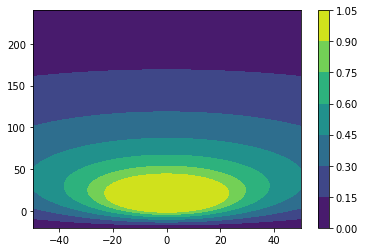

In [444]:
plt.contourf(R[:iZmax, iRmin:iRmax], Z[:iZmax, iRmin:iRmax], u.reshape((len(z), len(r)))[:iZmax, iRmin:iRmax])
plt.colorbar()

In [666]:
from dataclasses import dataclass

@dataclass
class Vq:
    r0 : float
    z0 : float
    q : float
    
    def __call__(self, r, z):
        dist = np.sqrt((r - self.r0)**2 + (z-self.z0)**2)
        return self.q * 1 / dist

In [659]:
q0 = Vq(0, 20.0, 20.0)
q1 = Vq(0, -60, -20.0)

In [660]:
q0(0.0, 0) + q1(0, 0)

0.6666666666666667

In [661]:
q0(0.0, -20) + q1(0, -20)

0.0

In [663]:
q0(5, 20-np.sqrt(20**2 - 5**2)) + q1(5, np.sqrt(20**2 - 5**2))

0.7484980969143948

In [664]:
E_rz.shape

(1300, 1200)

In [665]:
q0(5, np.sqrt(20**2 - 5**2))

3.9681187850686666